# Import libraries

In [12]:
import warnings
warnings.filterwarnings( 'ignore' )

# Basic libraries
import os
import pickle
import numpy    as np
import pandas   as pd
import matplotlib.pyplot as plt

# Optuna library
import optuna
# Random Forest
from sklearn.ensemble import RandomForestClassifier
# User libraries
from utils.Logger import *
from utils.utils import *
from utils.mlflow_logging import MLflow_log_performance
from utils.utils import copyDirTree

# Parameters

In [13]:
# Number of Optuna trials 
n_trials = 5
# Seed
seed = 42 
# Create logger
VERBOSE = True 
# Number of splits for Stratified Cross-Validation
n_splits = 5
# Hold-out percentage
test_size = 0.2

# Create temp directory for storing output figures
if not os.path.isdir('Performance'): os.mkdir('Performance')

In [14]:
# Initiate logger
if VERBOSE:
    logger = init_logger(log_file = 'logs.log') 

# Data

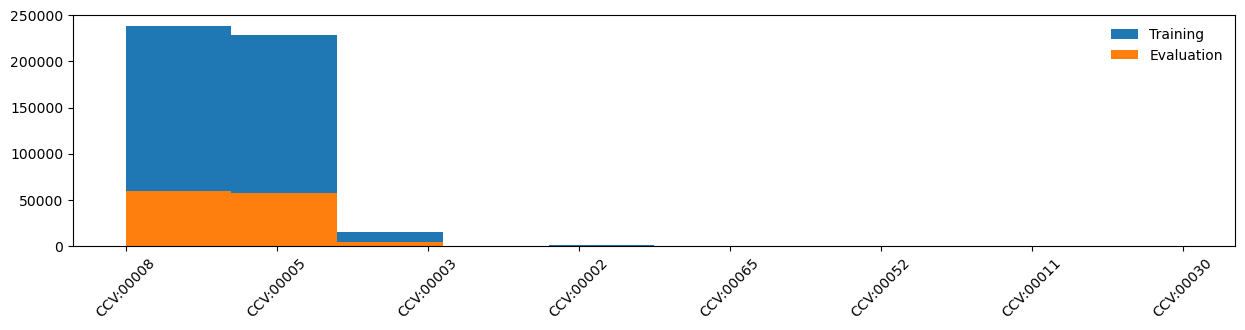

In [15]:
# Load data
X = np.load('Data/data.npz', allow_pickle=True)['X']
y = np.load('Data/data.npz', allow_pickle=True)['y']
if VERBOSE:
    logger.info('Data loaded')


# Split data (training/hold-out set)
from sklearn.model_selection import train_test_split
trainX, testX, trainY, testY = train_test_split(X, y, test_size=test_size, stratify=y, random_state=seed)
if VERBOSE:
    logger.info('Hold-out set is obtained')


# Class visualization
plt.figure(figsize=(15, 3))
plt.hist(trainY);
plt.hist(testY);
plt.xticks(rotation=45);
plt.legend(['Training', 'Evaluation'], frameon=False)

# Label encoding for targe class
from sklearn.preprocessing import LabelEncoder
# Use Label encoder used also by XGBoost
le = pickle.load(open('Label_encoder.pkl', 'rb'))
trainY = le.transform(trainY)
testY = le.transform(testY)
# Get classes/labels
labels = list(le.classes_)
if VERBOSE:
    logger.info('Label encoding of target variable is performed')

# Hyperparameter optimization

In [16]:
# Initiate mlflow server
# Command: mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./artifacts --host 127.0.0.1 --port 5000
# 
import mlflow
mlflow.set_tracking_uri("http://127.0.0.1:5000/")
mlflow.set_experiment("Use case: GRE")

if VERBOSE:
    logger.info('MLFlow server is connected')

## Prediction model

In [17]:
def objective(trial: optuna.trial.Trial) -> float: 
    # Logger
    if VERBOSE:
        logger.info(f'Trail: {trial.number} started [{trial.datetime_start}]')

    # Parameters
    params = {
        'n_estimators'      : trial.suggest_categorical('n_estimators', [100, 300, 500]),
        'max_depth'         : trial.suggest_categorical('max_depth', [5, 10, 15]),
    }


    # Setup model
    model = RandomForestClassifier(n_jobs=-1, 
                                   class_weight='balanced',
                                   **params)
    
    # Cross-Validation
    # train_CV_results, test_CV_results, CM_cv = cross_validation(model=model, X=trainX, Y=trainY, n_splits=n_splits, seed=seed, VERBOSE=VERBOSE)

    # Single-run 
    model, train_results, test_results, CM, predictions = single_run(model=model, trainX=trainX, trainY=trainY, testX=testX, testY=testY, VERBOSE=VERBOSE)

         
    if VERBOSE:
        logger.info(f'Trail: {trial.number} completed')

    # Include model signature
    signature = mlflow.models.infer_signature(testX, predictions)
    # Log performance to MLflow 
    MLflow_log_performance(trial.number, model, labels,
                        #    train_CV_results, test_CV_results, CM_cv, 
                           None, None, None,
                           train_results, test_results, CM,
                           signature, params)

    # Copy artifacts
    copyDirTree('./artifacts', '../artifacts')
    
    if VERBOSE:
        logger.info(f'Trail: {trial.number} Performance metrics & model logged')

    return np.mean(test_results['AUC'])

## Hyperparameter optimization process

In [18]:
study = optuna.create_study(direction='maximize',
                            sampler=optuna.samplers.TPESampler(seed = seed),
                           )

study.optimize(func=objective, 
               n_trials=n_trials, 
               n_jobs=1,)

[I 2023-06-25 11:01:06,466] A new study created in memory with name: no-name-42be39a0-b395-4483-8773-506cea9ee08f
[I 2023-06-25 11:06:40,364] Trial 0 finished with value: 0.84036131968857 and parameters: {'n_estimators': 300, 'max_depth': 5}. Best is trial 0 with value: 0.84036131968857.
[I 2023-06-25 11:20:53,873] Trial 1 finished with value: 0.7918670618773445 and parameters: {'n_estimators': 300, 'max_depth': 15}. Best is trial 0 with value: 0.84036131968857.
[I 2023-06-25 11:25:36,825] Trial 2 finished with value: 0.7906733462002049 and parameters: {'n_estimators': 100, 'max_depth': 15}. Best is trial 0 with value: 0.84036131968857.
[I 2023-06-25 11:48:24,279] Trial 3 finished with value: 0.7922196257893714 and parameters: {'n_estimators': 500, 'max_depth': 15}. Best is trial 0 with value: 0.84036131968857.
[I 2023-06-25 11:58:18,560] Trial 4 finished with value: 0.8012858504153592 and parameters: {'n_estimators': 300, 'max_depth': 10}. Best is trial 0 with value: 0.84036131968857.

In [19]:
# Delete temp directory
import shutil
shutil.rmtree('Performance')
shutil.rmtree('artifacts')

### Visualization of the learning curves of the trials


In [20]:
optuna.visualization.plot_optimization_history(study)

### Visualization of hyperparameter relationships


In [21]:
optuna.visualization.plot_parallel_coordinate(study, params=[params for params in study.best_params])

### Hyperparameter importances


In [22]:
optuna.visualization.plot_param_importances(study, 
                                            target      = lambda t: t.duration.total_seconds(), 
                                            target_name = "duration")

### Get optimized hyperparameters

In [23]:
print('[INFO] Optimized hyperparameters\n')
for (parameter,value) in study.best_params.items():
    if ( isinstance(value, float) ):
        print(' >%25s: %.3f' % (parameter,value))
    else:
        print(' >%25s: %s' % (parameter,value))

[INFO] Optimized hyperparameters

 >             n_estimators: 300
 >                max_depth: 5
